In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import cv2 as cv
from matplotlib.pyplot import GridSpec
import os

from scipy.ndimage.morphology import binary_fill_holes

# Data loading

In [5]:
def load_images(path_to_img_folder, list_images):
    imgs = [cv.imread(os.path.join(path_to_img_folder,img_name)) for img_name in list_images]
    return imgs

In [6]:
PATH_TO_IMAGES = '/home/bohdan/histologie/data/images/'
PATH_TO_MASKS = '/home/bohdan/histologie/data/masks/'

list_images = os.listdir(PATH_TO_IMAGES)

In [4]:
imgs = load_images(PATH_TO_IMAGES, list_images)
masks = load_images(PATH_TO_MASKS, list_images)

In [5]:
list_images

['5DM_0065.JPG',
 '5DM_0067.JPG',
 '5DM_0079.JPG',
 '5DM_0081.JPG',
 '5DM_0099.JPG',
 '5DM_0035.JPG',
 '5DM_0037.JPG',
 '5DM_0039.JPG',
 '5DM_0008.JPG',
 '5DM_0010.JPG',
 '5DM_0012.JPG',
 '5DM_0095.JPG',
 '5DM_0097.JPG',
 '5DM_0093.jpg']

# Minimal EDA

In [27]:
mywidth = 1024
img = Image.open('/home/bohdan/histologie/data/images/'+list_images[7])
# wpercent = (mywidth/float(img.size[0]))
# hsize = int((float(img.size[1])*float(wpercent)))
# img = img.resize((mywidth,hsize), PIL.Image.ANTIALIAS)
img.size

(5760, 3840)

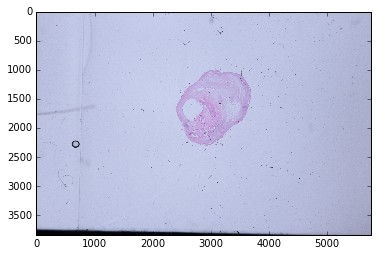

In [29]:
plt.imshow(img)

In [28]:
img = np.asarray(img)
img.shape

(3840, 5760, 3)

In [194]:
# img = cv.imread('/home/bohdan/histologie/data/images/'+list_images[2])
# img = cv.resize(img,(1024,1024))
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
blur = cv.medianBlur(gray,5)
blur_gaussian = cv.GaussianBlur(gray,(5,5),0)

In [195]:
img.shape

(682, 1024, 3)

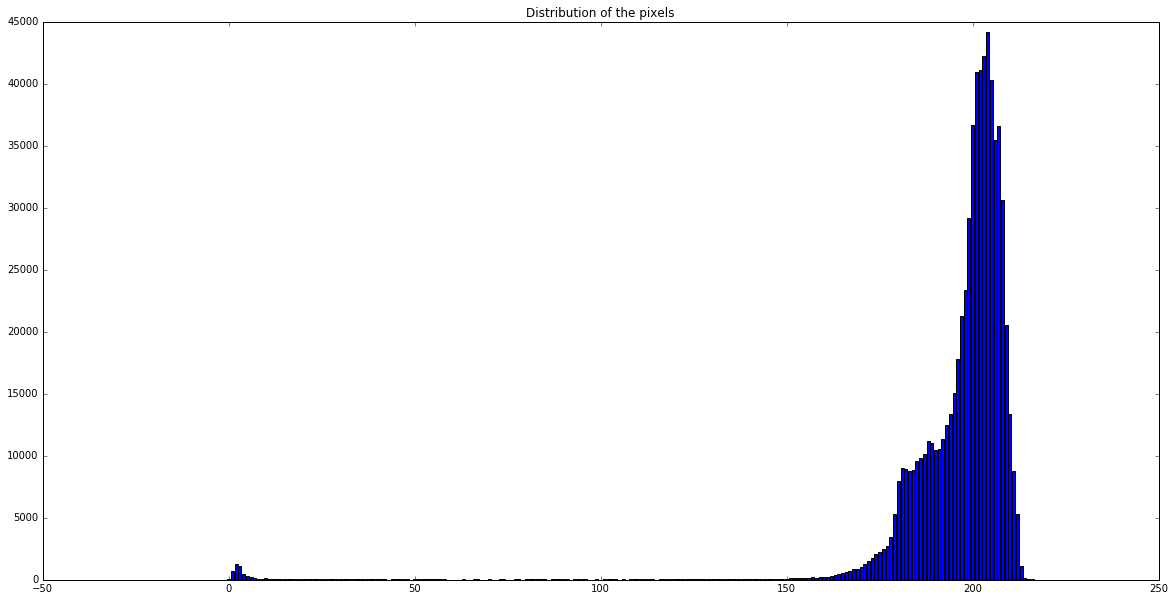

In [196]:
unique, counts =  np.unique(gray, return_counts=True)
D = dict(zip(unique, counts))
plt.figure(figsize=(20,10))
plt.bar(range(len(D)), list(D.values()), align='center')
plt.title('Distribution of the pixels')

(-0.5, 1023.5, 681.5, -0.5)

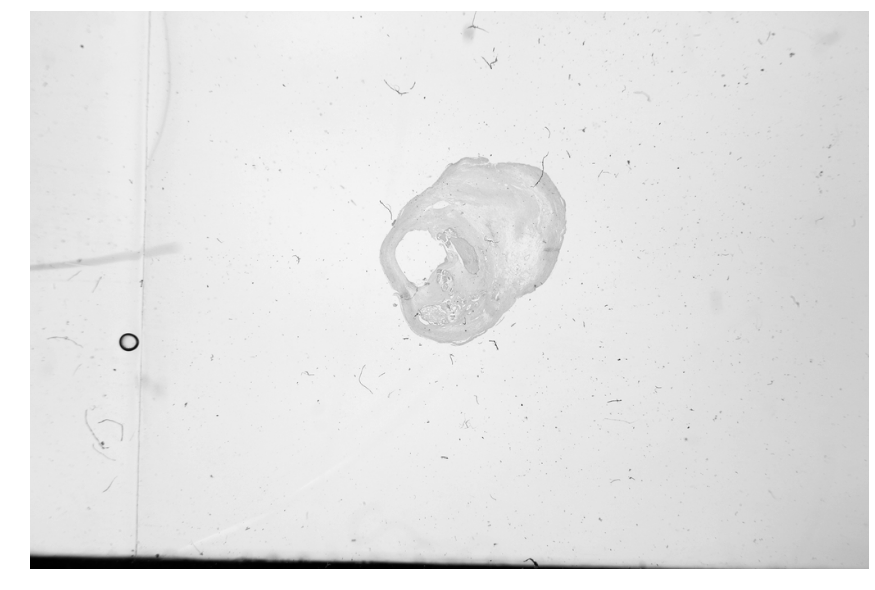

In [197]:
plt.figure(figsize=(20,10))
plt.imshow(gray, cmap='gray')
plt.axis('Off')

# Segmentation Algorithms
### Thresholding

In [198]:
methods = [
    ("THRESH_BINARY", cv.THRESH_BINARY),
    ("THRESH_BINARY_INV", cv.THRESH_BINARY_INV),
    ("THRESH_TRUNC", cv.THRESH_TRUNC),
    ("THRESH_TOZERO", cv.THRESH_TOZERO),
    ("THRESH_TOZERO_INV", cv.THRESH_TOZERO_INV)]

In [199]:
thresholds = {}
for (threshName, threshMethod) in methods:
    # threshold the image and show it
    (T, thresh) = cv.threshold(gray, 185, 232, threshMethod)
    thresholds[threshName] = thresh

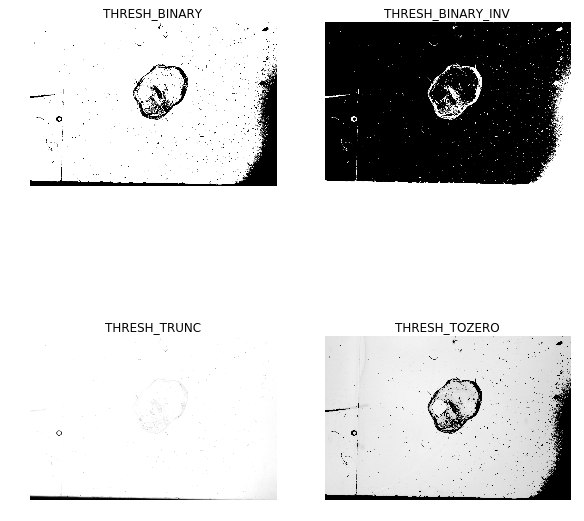

In [200]:
f = plt.figure(figsize=(20,10))
cols=2; rows=2

for i in range(1, cols*rows+1):
    f.add_subplot(rows, cols, i)
    method_name = methods[i - 1][0]
    matplotlib.pyplot.subplots_adjust(left  = 0.125,right = 0.5, bottom = 0.1, top = 0.9, wspace = 0.2, hspace = 0.2)
    plt.title(method_name)
    plt.imshow(thresholds[method_name], cmap='gray')
    plt.axis("Off")

### Adaptive Thresholding

In [245]:
def get_extent_of_the_contour(cnt):
    """
    Return extent of the given contour
    
    """
    area = cv.contourArea(cnt)
    x,y,w,h = cv.boundingRect(cnt)
    rect_area = w*h
    extent = float(area) / rect_area
    return extent

def filter_of_bad_contours(contours, hierarchy, minArea=2500, extentThreshold=0.01):
    """
    Filter bad contours based on two criterions: contour`s area and extent properties.
    
    Returns:
     - tuple(filtered_contours, corresponding_hierarchy)
     
    """
    filtered_by_area = [cnt for cnt in contours if (cv.contourArea(cnt) > minArea)]
    filtered_corresponging_hierarchies_by_area = []
    for i in range(len(contours)):
        if (cv.contourArea(contours[i]) > minArea):
            filtered_corresponging_hierarchies_by_area.append(hierarchy[0][i])

    filtered_by_extent = []
    filtered_corr_hierarchieds_by_extent = []
    for i in range(len(filtered_by_area)):
        cnt = filtered_by_area[i]
        extent = get_extent_of_the_contour(cnt)
        if extent > extentThreshold:
            filtered_by_extent.append(filtered_by_area[i])
            filtered_corr_hierarchieds_by_extent.append(
                filtered_corresponging_hierarchies_by_area[i])

    return filtered_by_extent, filtered_corr_hierarchieds_by_extent#filtered_by_area,filtered_corresponging_hierarchies_by_area

def fill_contours(arr):
    return np.maximum.accumulate(arr,1) & \
           np.maximum.accumulate(arr[::-1],1)[::-1]
    

In [246]:
adaptive_thresholds_names = [
    ("Adaptive Threash Mean", cv.ADAPTIVE_THRESH_MEAN_C),
    ("Adaptive Thresh Gaussian", cv.ADAPTIVE_THRESH_GAUSSIAN_C)
]
adaptive_thresholds = {}
for (threshName, threshMethod) in adaptive_thresholds_names:
    threshold = cv.adaptiveThreshold(gray,255,threshMethod,cv.THRESH_BINARY,15,4)
    adaptive_thresholds[threshName] = threshold

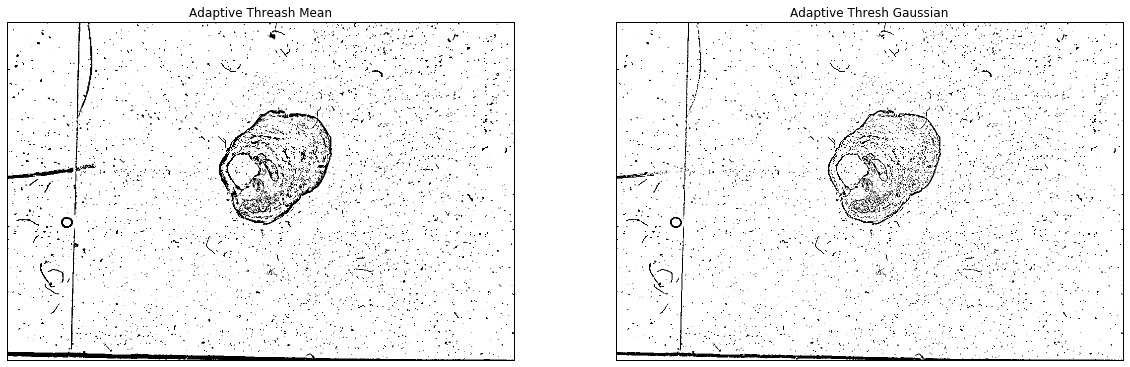

In [247]:
plt.figure(figsize=(20,10))
for i in range(2):
    plt.subplot(1,2,i+1)
#     opening = cv.morphologyEx(adaptive_thresholds[i], cv.MORPH_OPEN,np.ones((3,3),np.uint8))
#     closing = cv.morphologyEx(opening, cv.MORPH_CLOSE, np.ones((3,3),np.uint8))
#     plt.imshow(closing, 'gray')
    plt.imshow(adaptive_thresholds[adaptive_thresholds_names[i][0]], 'gray')
    plt.title(adaptive_thresholds_names[i][0])
    plt.xticks([]),plt.yticks([])
plt.show()

In [248]:
im2, contours, hierarchy = cv.findContours(255 - adaptive_thresholds['Adaptive Threash Mean'], 
                                           cv.RETR_TREE, cv.CHAIN_APPROX_NONE)


In [249]:
filtered_cnts, filtered_hierarchy = filter_of_bad_contours(contours, hierarchy)

In [250]:
filtered_hierarchy

[array([34, 31, 33, -1], dtype=int32)]

In [251]:
lol = cv.drawContours(np.copy(np.zeros((img.shape[0], img.shape[1]))), 
                      filtered_cnts, -1, 255, 3)
# lol = binary_fill_holes(lol).astype(np.uint8)
# lol = fill_contours(lol,)
# lol = cv.drawContours(np.copy(lol), 
#                       [filtered_cnts[1]], -1, 0, 3)

(-0.5, 1023.5, 681.5, -0.5)

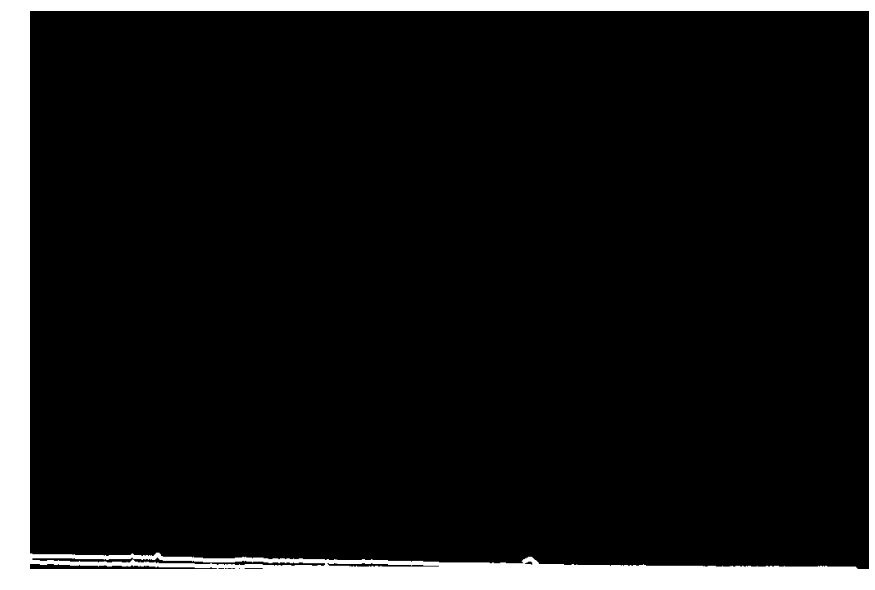

In [252]:
plt.figure(figsize=(20,10))
plt.imshow(lol, 'gray')
plt.axis('Off')

### Canny Edge Detector

225

In [253]:
edges = cv.Canny(blur,100, 200 )

(<matplotlib.text.Text at 0x7f7cd58f0160>,
 ([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

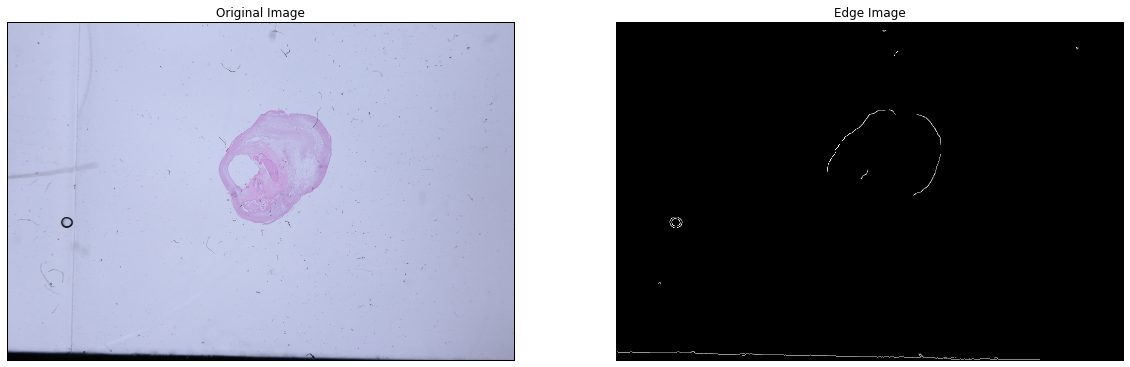

In [254]:
plt.figure(figsize=(20,10))
plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])